## Setup

In [1]:
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences

import pandas as pd

tfds.disable_progress_bar()

2025-04-29 16:11:29.229115: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745957489.245177 1911043 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745957489.250064 1911043 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745957489.264258 1911043 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745957489.264272 1911043 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745957489.264274 1911043 computation_placer.cc:177] computation placer alr

Import `matplotlib` and create a helper function to plot graphs:

In [2]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

## Setup input pipeline


The IMDB large movie review dataset is a *binary classification* dataset—all the reviews have either a *positive* or *negative* sentiment.

Download the dataset using [TFDS](https://www.tensorflow.org/datasets). See the [loading text tutorial](https://www.tensorflow.org/tutorials/load_data/text) for details on how to load this sort of data manually.


In [3]:
# dataset, info = tfds.load('imdb_reviews', with_info=True,
#                           as_supervised=True)
# train_dataset, test_dataset = dataset['train'], dataset['test']

# train_dataset.element_spec

In [4]:
data = pd.read_csv("classified_spam.csv")
# text = data["text"]
# is_spam = data["label_num"]
# text_class = data["classification"] 

TEXT_COLUMN = 'text'
LABEL_COLUMN = 'classification'
label_encoder = LabelEncoder()

def df_to_tf_dataset(df, text_column, label_column):
    return tf.data.Dataset.from_tensor_slices((
        df[text_column].values,  # Features
        label_encoder.fit_transform(df[label_column])   # Labels
    ))

dataset = df_to_tf_dataset(data, TEXT_COLUMN, LABEL_COLUMN)

train_size = int(len(data) * 0.8)
train_dataset = dataset.take(train_size)
test_dataset = dataset.skip(train_size)

# Specify output types
train_dataset = train_dataset.map(lambda x, y: (x, y))  # Map to appropriate data types
test_dataset = test_dataset.map(lambda x, y: (x, y))  # Map to appropriate data types

I0000 00:00:1745957495.424658 1911043 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22395 MB memory:  -> device: 0, name: NVIDIA RTX A5000, pci bus id: 0000:01:00.0, compute capability: 8.6
I0000 00:00:1745957495.427096 1911043 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22395 MB memory:  -> device: 1, name: NVIDIA RTX A5000, pci bus id: 0000:23:00.0, compute capability: 8.6
I0000 00:00:1745957495.428921 1911043 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 22395 MB memory:  -> device: 2, name: NVIDIA RTX A5000, pci bus id: 0000:41:00.0, compute capability: 8.6
I0000 00:00:1745957495.430736 1911043 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 22395 MB memory:  -> device: 3, name: NVIDIA RTX A5000, pci bus id: 0000:61:00.0, compute capability: 8.6
I0000 00:00:1745957495.432979 1911043 gpu_device.cc:2019] Created device /job:localh

Initially this returns a dataset of (text, label pairs):

In [5]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"Subject: enron methanol ; meter # : 988291\r\nthis is a follow up to the note i gave you on monday , 4 / 3 / 00 { preliminary\r\nflow data provided by daren } .\r\nplease override pop ' s daily volume { presently zero } to reflect daily\r\nactivity you can obtain from gas control .\r\nthis change is needed asap for economics purposes ."
label:  2


2025-04-29 16:11:35.631046: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Next shuffle the data for training and create batches of these `(text, label)` pairs:

In [6]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [7]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [8]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b'I know you mood off today'
 b'Subject: wc 551 cancellation of force majeure effective 6 / 6 / 00\r\n- - - - - - - - - - - - - - - - - - - - - - forwarded by ami chokshi / corp / enron on 06 / 07 / 2000\r\n11 : 17 am - - - - - - - - - - - - - - - - - - - - - - - - - - -\r\n" steve holmes " on 06 / 07 / 2000 10 : 47 : 25 am\r\nto :\r\ncc :\r\nsubject : wc 551 cancellation of force majeure effective 6 / 6 / 00\r\nami ,\r\nthe attached is a notice canceling the force majeure situation on wc 551\r\neffective 6 / 6 / 00 . the platform was down 5 / 30 / 00 - 6 / 5 / 00 .\r\nlet me know of any questions you have .\r\nsteve\r\n- wc 551 forcemajeureo 530002 cancellation . doc'
 b"Subject: harassment avoidance - clarification\r\n* * clarification * *\r\nharassment prevention training\r\nthis training is mandatory for all enron employees employed since the last\r\nseminar was conducted in late 1998 or early 1999 . those who have already\r\nattended enron harassment avoidance training wi

2025-04-29 16:11:35.678986: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## Create the text encoder

The raw text loaded by `tfds` needs to be processed before it can be used in a model. The simplest way to process text for training is using the `TextVectorization` layer. This layer has many capabilities, but this tutorial sticks to the default behavior.

Create the layer, and pass the dataset's text to the layer's `.adapt` method:

In [9]:
VOCAB_SIZE = 1000
max_sequence_length = 20
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE,
)
encoder.adapt(train_dataset.map(lambda text, label: text))

The `.adapt` method sets the layer's vocabulary. Here are the first 20 tokens. After the padding and unknown tokens they're sorted by frequency: 

In [10]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'of', 'to', 'and', 'a', 'in', 'for', 'is',
       'you', 'i', 'on', 'this', 'be', 'that', 'ect', 'will', 'with',
       'are'], dtype='<U14')

Once the vocabulary is set, the layer can encode text into indices. The tensors of indices are 0-padded to the longest sequence in the batch (unless you set a fixed `output_sequence_length`):

In [11]:
encoded_example = encoder(example)[:3].numpy()
print(encoded_example)

[[11 91 10 ...  0  0  0]
 [30  1  1 ...  0  0  0]
 [30  1  1 ...  0  0  0]]


With the default settings, the process is not completely reversible. There are three main reasons for that:

1. The default value for `preprocessing.TextVectorization`'s `standardize` argument is `"lower_and_strip_punctuation"`.
2. The limited vocabulary size and lack of character-based fallback results in some unknown tokens.

In [12]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'I know you mood off today'
Round-trip:  i know you [UNK] off today                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

Original:  b'Subject: wc 551 cancellation of force majeure effective 6 / 6 / 00\r\n- - - - - - - - - - - - - - - - - - - - - - forwarded by ami chokshi / corp / enron on 06 / 07 / 2000\r\n11 : 17 am - - - - - - - - - - - - - - - - - - - - - - - - - - -\r\n" steve holmes " on 06 / 07 / 2000 10 : 47 : 25 am\r\nto :\r\ncc :\r\nsubject : wc 551 cancellation of force majeure effective 6 / 6 / 00\r\nami ,\r\nthe attached is a notice canceling the force majeure situation o

## Create the model

![A drawing of the information flow in the model](images/bidirectional.png)

Above is a diagram of the model. 

1. This model can be build as a `tf.keras.Sequential`.

2. The first layer is the `encoder`, which converts the text to a sequence of token indices.

3. After the encoder is an embedding layer. An embedding layer stores one vector per word. When called, it converts the sequences of word indices to sequences of vectors. These vectors are trainable. After training (on enough data), words with similar meanings often have similar vectors.

  This index-lookup is much more efficient than the equivalent operation of passing a one-hot encoded vector through a `tf.keras.layers.Dense` layer.

4. A recurrent neural network (RNN) processes sequence input by iterating through the elements. RNNs pass the outputs from one timestep to their input on the next timestep.

  The `tf.keras.layers.Bidirectional` wrapper can also be used with an RNN layer. This propagates the input forward and backwards through the RNN layer and then concatenates the final output. 

  * The main advantage of a bidirectional RNN is that the signal from the beginning of the input doesn't need to be processed all the way through every timestep to affect the output.  

  * The main disadvantage of a bidirectional RNN is that you can't efficiently stream predictions as words are being added to the end.

5. After the RNN has converted the sequence to a single vector the two `layers.Dense` do some final processing, and convert from this vector representation to a single logit as the classification output. 


The code to implement this is below:

In [13]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(len(label_encoder.classes_), activation='softmax')
])

Please note that Keras sequential model is used here since all the layers in the model only have single input and produce single output. In case you want to use stateful RNN layer, you might want to build your model with Keras functional API or model subclassing so that you can retrieve and reuse the RNN layer states. Please check [Keras RNN guide](https://www.tensorflow.org/guide/keras/rnn#rnn_state_reuse) for more details.

The embedding layer [uses masking](https://www.tensorflow.org/guide/keras/masking_and_padding) to handle the varying sequence-lengths. All the layers after the `Embedding` support masking:

In [14]:
print([layer.supports_masking for layer in model.layers])

[False, False, True, True, True]


To confirm that this works as expected, evaluate a sentence twice. First, alone so there's no padding to mask:

In [15]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
print(sample_text)
predictions = model.predict(np.array([sample_text], dtype=object))
print(predictions[0])

The movie was cool. The animation and the graphics were out of this world. I would recommend this movie.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 682ms/step

I0000 00:00:1745957498.098851 1911498 cuda_dnn.cc:529] Loaded cuDNN version 90300


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 745ms/step
[0.14305037 0.14262477 0.14551951 0.14210473 0.14097445 0.14437364
 0.14135247]


Now, evaluate it again in a batch with a longer sentence. The result should be identical:

In [16]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding], dtype=object))
print(predictions[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step
[0.14268835 0.14217348 0.14540757 0.1400828  0.13928473 0.14616188
 0.14420116]


Compile the Keras model to configure the training process:

In [17]:
# model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
#               optimizer=tf.keras.optimizers.Adam(1e-4),
#               metrics=['accuracy'])
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',  # Use categorical_crossentropy if your labels are one-hot encoded
              metrics=['accuracy'])

## Train the model

In [18]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
246/246 ━━━━━━━━━━━━━━━━━━━━ 21s 74ms/step - accuracy: 0.8085 - loss: 0.7768 - val_accuracy: 0.8776 - val_loss: 0.3432
Epoch 2/10
246/246 ━━━━━━━━━━━━━━━━━━━━ 18s 72ms/step - accuracy: 0.8957 - loss: 0.3469 - val_accuracy: 0.9193 - val_loss: 0.2827
Epoch 3/10
246/246 ━━━━━━━━━━━━━━━━━━━━ 18s 73ms/step - accuracy: 0.9163 - loss: 0.2857 - val_accuracy: 0.9302 - val_loss: 0.2603
Epoch 4/10
246/246 ━━━━━━━━━━━━━━━━━━━━ 18s 73ms/step - accuracy: 0.9188 - loss: 0.2735 - val_accuracy: 0.9344 - val_loss: 0.2265
Epoch 5/10
246/246 ━━━━━━━━━━━━━━━━━━━━ 18s 74ms/step - accuracy: 0.9233 - loss: 0.2614 - val_accuracy: 0.9438 - val_loss: 0.2242
Epoch 6/10
246/246 ━━━━━━━━━━━━━━━━━━━━ 18s 72ms/step - accuracy: 0.9266 - loss: 0.2467 - val_accuracy: 0.9443 - val_loss: 0.2209
Epoch 7/10
246/246 ━━━━━━━━━━━━━━━━━━━━ 18s 73ms/step - accuracy: 0.9340 - loss: 0.2235 - val_accuracy: 0.9484 - val_loss: 0.2043
Epoch 8/10
246/246 ━━━━━━━━━━━━━━━━━━━━ 18s 74ms/step - accuracy: 0.9412 - loss: 0.2041 - 

In [19]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9564 - loss: 0.1581
Test Loss: 0.16771835088729858
Test Accuracy: 0.9523202180862427


(0.0, 0.5693074092268944)

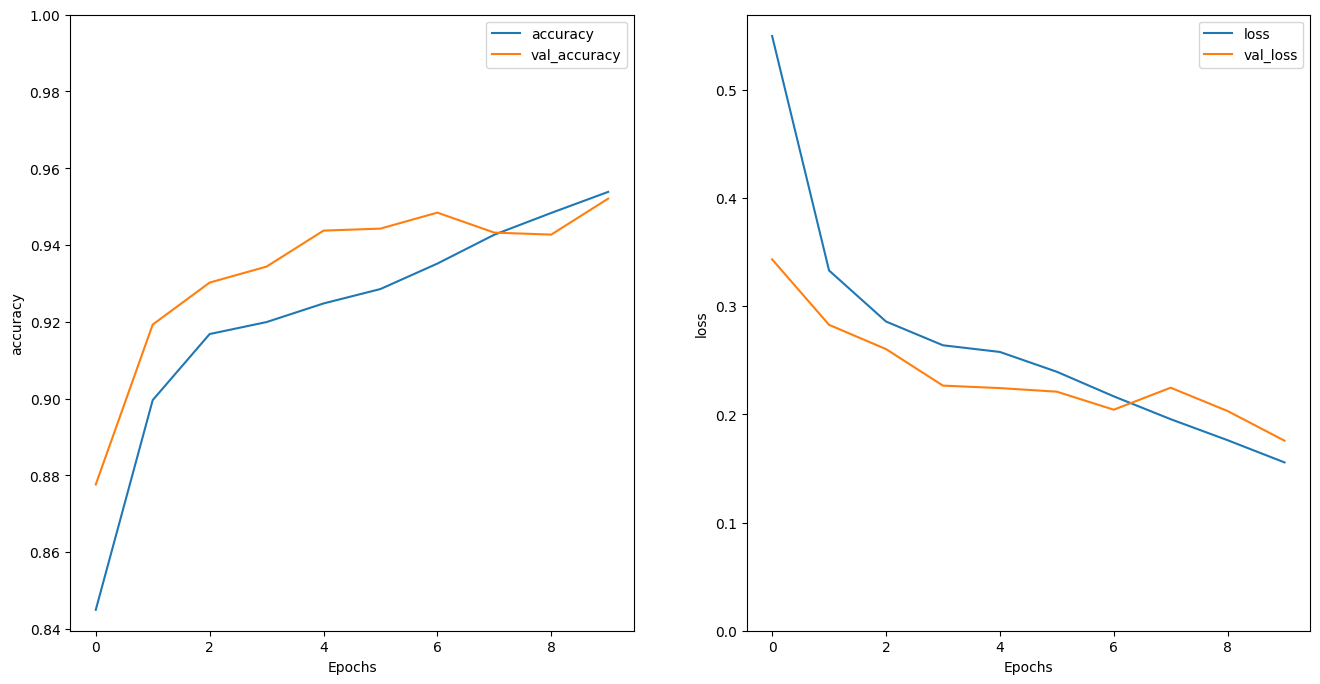

In [20]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

Run a prediction on a new sentence:

If the prediction is >= 0.0, it is positive else it is negative.

In [21]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text], dtype=object))
print(predictions[0])
for i, c in enumerate(label_encoder.classes_):
    print(f"{c}: {predictions[0][i]*100:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step
[0.03716921 0.02984351 0.5010842  0.07232725 0.0081361  0.01577751
 0.33566222]
financial/banking spam: 3.72%
general spam: 2.98%
ham: 50.11%
job/employment spam: 7.23%
malware spam: 0.81%
phishing spam: 1.58%
prize/lottery spam: 33.57%


## Stack two or more LSTM layers

Keras recurrent layers have two available modes that are controlled by the `return_sequences` constructor argument:

* If `False` it returns only the last output for each input sequence (a 2D tensor of shape (batch_size, output_features)). This is the default, used in the previous model.

* If `True` the full sequences of successive outputs for each timestep is returned (a 3D tensor of shape `(batch_size, timesteps, output_features)`).

Here is what the flow of information looks like with `return_sequences=True`:

![layered_bidirectional](images/layered_bidirectional.png)

The interesting thing about using an `RNN` with `return_sequences=True` is that the output still has 3-axes, like the input, so it can be passed to another RNN layer, like this:

In [22]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(label_encoder.classes_), activation='softmax')
])

In [23]:
# model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
#               optimizer=tf.keras.optimizers.Adam(1e-4),
#               metrics=['accuracy'])
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',  # Use categorical_crossentropy if your labels are one-hot encoded
              metrics=['accuracy'])

In [24]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
246/246 ━━━━━━━━━━━━━━━━━━━━ 37s 137ms/step - accuracy: 0.7915 - loss: 0.8147 - val_accuracy: 0.8427 - val_loss: 0.4245
Epoch 2/10
246/246 ━━━━━━━━━━━━━━━━━━━━ 33s 135ms/step - accuracy: 0.8684 - loss: 0.4439 - val_accuracy: 0.8599 - val_loss: 0.3857
Epoch 3/10
246/246 ━━━━━━━━━━━━━━━━━━━━ 33s 134ms/step - accuracy: 0.8827 - loss: 0.3834 - val_accuracy: 0.8740 - val_loss: 0.3474
Epoch 4/10
246/246 ━━━━━━━━━━━━━━━━━━━━ 32s 130ms/step - accuracy: 0.8971 - loss: 0.3413 - val_accuracy: 0.8755 - val_loss: 0.3307
Epoch 5/10
246/246 ━━━━━━━━━━━━━━━━━━━━ 33s 136ms/step - accuracy: 0.8940 - loss: 0.3259 - val_accuracy: 0.8760 - val_loss: 0.3415
Epoch 6/10
246/246 ━━━━━━━━━━━━━━━━━━━━ 34s 137ms/step - accuracy: 0.9053 - loss: 0.2911 - val_accuracy: 0.8651 - val_loss: 0.3676
Epoch 7/10
246/246 ━━━━━━━━━━━━━━━━━━━━ 34s 138ms/step - accuracy: 0.8928 - loss: 0.3301 - val_accuracy: 0.9052 - val_loss: 0.2954
Epoch 8/10
246/246 ━━━━━━━━━━━━━━━━━━━━ 34s 139ms/step - accuracy: 0.9060 - loss: 0

In [25]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

 1/62 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9531 - loss: 0.2249

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9173 - loss: 0.2609
Test Loss: 0.27053624391555786
Test Accuracy: 0.9189189076423645


In [26]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text], dtype=object))
print(predictions)
for i, c in enumerate(label_encoder.classes_):
    print(f"{c}: {predictions[0][i]*100:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step
[[8.5625878e-05 6.4875977e-03 9.9251258e-01 8.1510218e-05 7.7797915e-05
  5.8206159e-04 1.7288921e-04]]
financial/banking spam: 0.01%
general spam: 0.65%
ham: 99.25%
job/employment spam: 0.01%
malware spam: 0.01%
phishing spam: 0.06%
prize/lottery spam: 0.02%


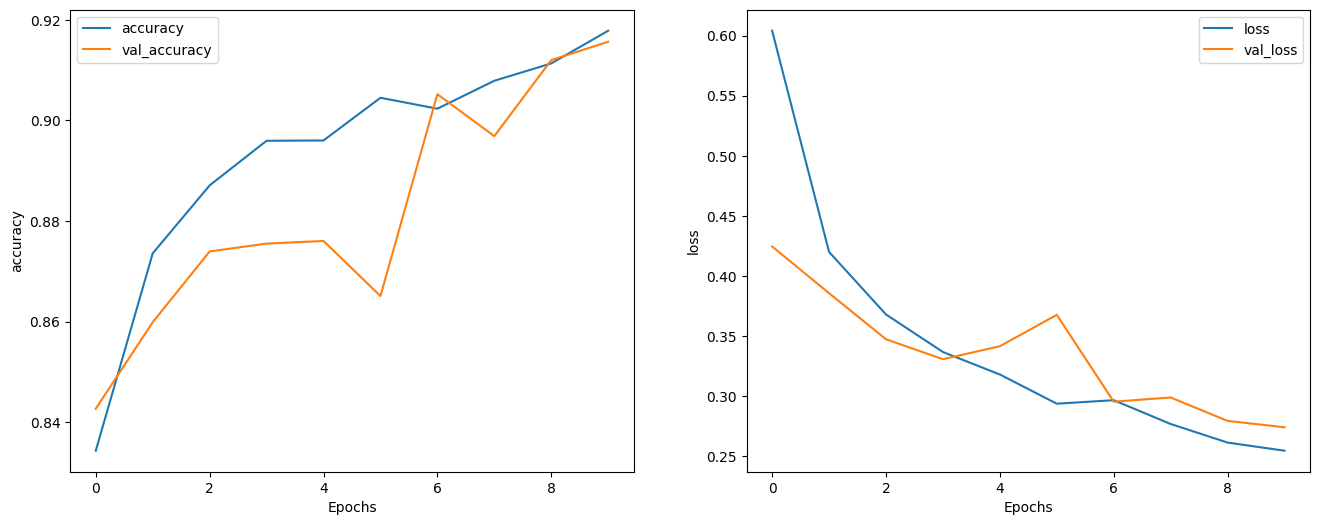

In [27]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')